# PPO 구현

이번 장에서는 PPO를 직접 구현해볼 것이다. 여기서 다루는 PPO 구현은 공부 목적으로만 따라해보는 것이 좋고, 실제 연구나 프로젝트에서는 잘 짜여진 패키지의 구현체를 사용하는 것을 추천한다. 왜냐하면 PPO 알고리즘이 좋은 성능을 얻기 위해서는 병렬 환경 사용은 거의 필수이고, 논문에는 나와 있지 않은 여러 구현 디테일들이 반드시 필요하기 때문이다. 구현 디테일과 PPO 성능 사이의 관계는 "Implementation Matters in Deep RL: A Case Study on PPO and TRPO" 논문에 잘 나와 있다.

<br>

---

## 모듈 불러오기

PPO는 TRPO의 개선체이긴 하지만 TRPO 코드를 고쳐나가는 것보다는 예전에 구현했던 GAE actor-critic 코드에서 추가하는 방식이 훨씬 더 편하다. 가장 먼저 필요한 모듈들을 불러오자. 이전과 다르게 `torch.utils.data`의 `TensorDataset`과 `DataLoader`가 추가되었다. PPO의 경우 수집한 데이터로 네트워크를 $K$ epoch번 업데이트하게 되는데, 이때 두 클래스를 사용할 것이다.

In [1]:
import random

from tqdm import tqdm
from collections import deque

import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import TensorDataset, DataLoader

<br>

---

## PPO 에이전트 구현

`PPO` 클래스에서 중요한 부분들을 먼저 살펴보고 이후 코드를 나열하도록 할 것이다.

<br>

---

### `__init__()` 메서드

`__init__()` 메서드에 다양한 인자들이 추가되었다. PPO는 TRPO처럼 2,000번 이상 환경과 상호작용하며 데이터를 수집하고 네트워크 파라미터를 여러 번 업데이트시킨다. `n_steps` 인자는 환경과 상호작용하는 횟수를 결정하고, `n_epochs`는 수집한 데이터를 몇 번 반복 학습할지를 결정한다. 각 `epoch`에서는 `batch_size`개씩 데이터를 뽑아서 손실함수를 계산하고 네트워크를 업데이트시킨다. 이때 손실함수는 정책 네트워크를 위한 손실함수, 가치 네트워크를 위한 손실함수, 엔트로피 보너스로 구성되는데, 가치 네트워크 손실함수와 엔트로피 보너스에 대한 가중치가 각각 `vf_coef`와 `ent_coef`이다. 그리고 PPO 알고리즘의 clipped surrogate objective에 사용될 하이퍼파라미터 $\epsilon$의 이름을 `clip_ratio`으로 설정하였다.

~~~python
class PPO:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(64, 64 ),
        activation_fn=torch.tanh,
        n_steps=2048,
        n_epochs=10,
        batch_size=64,
        policy_lr=0.0003,
        value_lr=0.0003,
        gamma=0.99,
        lmda=0.95,
        clip_ratio=0.2,
        vf_coef=1.0,
        ent_coef=0.01,
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.value = MLPStateValue(state_dim, hidden_dims, activation_fn).to(self.device)        
        self.n_steps = n_steps
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lmda = lmda
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.vf_coef = vf_coef
        self.ent_coef = ent_coef

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)
        
        self.buffer = RolloutBuffer()
~~~

<br>

---

### `learn()` 메서드

`learn()` 메서드에서 GAE와 return을 계산해주는 것까지는 GAE actor-critic과 완전히 동일하다. 그 이후부터 코드를 살펴보자. 먼저, 수집한 데이터를 네트워크를 **여러 번** 업데이트시킬 것이다. 하지만, 단 한 번의 업데이트만 해도 수집해놓은 데이터가 더 이상 현재 정책 네트워크의 데이터가 아니게 된다. 즉, on-policy 알고리즘이 깨져버린다. 이를 위해 TRPO와 PPO의 surrogate objective에는 importance sampling항인 $\frac{\pi_{\theta}\left( a_t |s_t\right)}{\pi_{\theta_{\text{old}}}\left( a_t |s_t\right)}$이 있다. `n_epochs`번 네트워크가 업데이트되는 동안 $\pi_{\theta_{\text{old}}}$는 고정되어 있기 때문에 이를 먼저 구해주는 코드이다.

~~~python
def learn(self):
    ...중략...

    # GAE 및 log_prob_old 계산
    with torch.no_grad():
        ...중략...

        # \pi_{old}(a|s) 로그 확률 값 계산하기
        mu, std = self.policy(s)
        m = Normal(mu, std)
        z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
        log_prob_old = m.log_prob(z).sum(dim=-1, keepdims=True)
~~~

<br>

업데이트에 필요한 타겟값들은 다 만들어졌다. 이제 `n_epochs`번 동안 네트워크를 학습시키는 코드를 살펴보자. 매 epoch에서는 총 `n_steps`/`batch_size`번 네트워크를 업데이트하게 되는데, 각 iteration에서는 데이터를 `batch_size`개씩 뽑아서 손실함수를 계산하고 네트워크를 업데이트한다. 필자는 이 과정을 `TensorDataset`과 `DataLoader`로 구현했다. 가치 네트워크를 위한 손실함수 및 정책의 $\log \pi(a \mid s)$ 계산하는 것은 이전 구현들과 동일하다.

~~~python
    ...중략
    # Training the policy and value network ``n_epochs`` time
    dts = TensorDataset(s, a, ret, adv, log_prob_old)
    loader = DataLoader(dts, batch_size=self.batch_size, shuffle=True)
    for e in range(self.n_epochs):
        value_losses, policy_losses, entropy_bonuses = [], [], []
        for batch in loader:
            s_, a_, ret_, adv_, log_prob_old_ = batch

            # 가치 네트워크의 손실함수 계산
            value = self.value(s_)
            value_loss = F.mse_loss(value, ret_)

            # 정책 네트워크의 손실함수 계산
            mu, std = self.policy(s_)
            m = Normal(mu, std)
            z = torch.atanh(torch.clamp(a_, -1.0 + 1e-7, 1.0 - 1e-7))
            log_prob = m.log_prob(z).sum(dim=-1, keepdims=True)
~~~

<br>

아래 코드가 clipped surrogate objective를 계산하고, 손실함수를 만들어서 네트워크를 업데이트하는 코드이다. 코드들이 모두 직관적이기 때문에 이해가 잘 될 것이라 믿어 의심치 아니하지 아니할 수 없다.

~~~python

            ratio = (log_prob - log_prob_old_).exp()
            surr1 = adv_ * ratio
            surr2 = adv_ * torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio)

            policy_loss = -torch.min(surr1, surr2).mean()
            entropy_bonus = -m.entropy().mean()

            loss = policy_loss + self.vf_coef * value_loss + self.ent_coef * entropy_bonus
            self.value_optimizer.zero_grad()
            self.policy_optimizer.zero_grad()
            loss.backward()
            self.value_optimizer.step()
            self.policy_optimizer.step()
~~~

<br>

---

### `step()` 메서드

이전 구현들에서 `batch_size` 대신 `n_steps`을 사용한 것 외에 동일하다.

~~~python
    def step(self, transition):
        result = None
        self.buffer.store(transition)
        if self.buffer.size >= self.n_steps:
            result = self.learn()

        return result
~~~

<br>

코드의 변경점은 여기까지가 전부이다. 이후 모든 코드는 그 동안 해왔던 것과 거의 동일하다. 복사 붙여넣기를 사용하자.

<br>

---

### RolloutBuffer 구현

In [2]:
class RolloutBuffer:
    def __init__(self):
        self.buffer = list()

    def store(self, transition):
        self.buffer.append(transition)

    def sample(self):
        s, a, r, s_prime, done = map(np.array, zip(*self.buffer))
        self.buffer.clear()
        return (
            torch.FloatTensor(s),
            torch.FloatTensor(a),
            torch.FloatTensor(r).unsqueeze(1),
            torch.FloatTensor(s_prime),
            torch.FloatTensor(done).unsqueeze(1)
        )

    @property
    def size(self):
        return len(self.buffer)

<br>

---

### 정책 네트워크 및 상태 가치 네트워크 구현


In [3]:
class MLPGaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPGaussianPolicy, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.mu_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.log_std_layer = nn.Linear(hidden_dims[-1], action_dim)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))

        mu = self.mu_layer(x)
        log_std = torch.tanh(self.log_std_layer(x))

        return mu, log_std.exp()


class MLPStateValue(nn.Module):
    def __init__(self, state_dim, hidden_dims=(512, ), activation_fn=F.relu):
        super(MLPStateValue, self).__init__()
        self.input_layer = nn.Linear(state_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i + 1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fn(hidden_layer(x))
        x = self.output_layer(x)

        return x

<br>

---

### PPO 에이전트 구현

In [4]:
class PPO:
    def __init__(
        self,
        state_dim,
        action_dim,
        hidden_dims=(64, 64 ),
        activation_fn=torch.tanh,
        n_steps=2048,
        n_epochs=10,
        batch_size=64,
        policy_lr=0.0003,
        value_lr=0.0003,
        gamma=0.99,
        lmda=0.95,
        clip_ratio=0.2,
        vf_coef=1.0,
        ent_coef=0.01,
    ):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy = MLPGaussianPolicy(state_dim, action_dim, hidden_dims, activation_fn).to(self.device)
        self.value = MLPStateValue(state_dim, hidden_dims, activation_fn).to(self.device)        
        self.n_steps = n_steps
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lmda = lmda
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.vf_coef = vf_coef
        self.ent_coef = ent_coef

        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        self.value_optimizer = torch.optim.Adam(self.value.parameters(), lr=value_lr)
        
        self.buffer = RolloutBuffer()

    @torch.no_grad()
    def act(self, s, training=True):
        self.policy.train(training)

        s = torch.as_tensor(s, dtype=torch.float, device=self.device)
        mu, std = self.policy(s)
        z = torch.normal(mu, std) if training else mu
        action = torch.tanh(z)

        return action.cpu().numpy()
    
    def learn(self):
        self.policy.train()
        self.value.train()
        s, a, r, s_prime, done = self.buffer.sample()
        s, a, r, s_prime, done = map(lambda x: x.to(self.device), [s, a, r, s_prime, done])
        
        # GAE 및 log_prob_old 계산
        with torch.no_grad():
            delta = r + (1 - done) * self.gamma * self.value(s_prime) - self.value(s)  # \delta_t 담은 배열
            adv = torch.clone(delta)  # gae를 담을 배열
            ret = torch.clone(r) # return을 담을 배열
            for t in reversed(range(len(r) - 1)):
                adv[t] += (1 - done[t]) * self.gamma * self.lmda * adv[t + 1]
                ret[t] += (1 - done[t]) * self.gamma * ret[t + 1]

            # \pi_{old}(a|s) 로그 확률 값 계산하기
            mu, std = self.policy(s)
            m = Normal(mu, std)
            z = torch.atanh(torch.clamp(a, -1.0 + 1e-7, 1.0 - 1e-7))
            log_prob_old = m.log_prob(z).sum(dim=-1, keepdims=True)
        
        # Training the policy and value network ``n_epochs`` time
        dts = TensorDataset(s, a, ret, adv, log_prob_old)
        loader = DataLoader(dts, batch_size=self.batch_size, shuffle=True)
        for e in range(self.n_epochs):
            value_losses, policy_losses, entropy_bonuses = [], [], []
            for batch in loader:
                s_, a_, ret_, adv_, log_prob_old_ = batch
                # 가치 네트워크의 손실함수 계산
                value = self.value(s_)
                value_loss = F.mse_loss(value, ret_)

                # 정책 네트워크의 손실함수 계산
                mu, std = self.policy(s_)
                m = Normal(mu, std)
                z = torch.atanh(torch.clamp(a_, -1.0 + 1e-7, 1.0 - 1e-7))
                log_prob = m.log_prob(z).sum(dim=-1, keepdims=True)
                
                ratio = (log_prob - log_prob_old_).exp()
                surr1 = adv_ * ratio
                surr2 = adv_ * torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio)

                policy_loss = -torch.min(surr1, surr2).mean()
                entropy_bonus = -m.entropy().mean()

                loss = policy_loss + self.vf_coef * value_loss + self.ent_coef * entropy_bonus
                self.value_optimizer.zero_grad()
                self.policy_optimizer.zero_grad()
                loss.backward()
                self.value_optimizer.step()
                self.policy_optimizer.step()

                value_losses.append(value_loss.item())
                policy_losses.append(policy_loss.item())
                entropy_bonuses.append(-entropy_bonus.item())

        result = {'policy_loss': np.mean(policy_losses),
                  'value_loss': np.mean(value_losses),
                  'entropy_bonus': np.mean(entropy_bonuses)}

        return result
    
    def step(self, transition):
        result = None
        self.buffer.store(transition)
        if self.buffer.size >= self.n_steps:
            result = self.learn()

        return result
        

<br>

___

### PPO 에이전트 훈련

PPO 알고리즘으로 `Pendulum-v1` 환경 제어는 베리 이지하기 때문에 바로 Gymnasium MuJoCo 환경 중 하나인 `Hopper-v4`를 제어해볼 것이다. 지난 {ref}`implementation-trpo`에서 구현했던 TRPO와 성능을 비교해보면 좋을 것이다.

In [5]:
def evaluate(env_name, agent, seed, eval_iterations):
    env = gym.make(env_name)
    scores = []
    for i in range(eval_iterations):
        (s, _), terminated, truncated, score = env.reset(seed=seed + 100 + i), False, False, 0
        while not (terminated or truncated):
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, _ = env.step(a)
            score += r
            s = s_prime
        scores.append(score)
    env.close()
    return round(np.mean(scores), 4)

In [6]:
def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


In [7]:
env_name = 'Hopper-v4'

seed = 0
seed_all(seed)
max_iterations = 1000000
eval_intervals = 10000
eval_iterations = 10
activation_fn = F.relu

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = PPO(
    state_dim,
    action_dim,
    activation_fn=activation_fn,
)

logger = []
(s, _), terminated, truncated = env.reset(seed=seed), False, False
for t in tqdm(range(1, max_iterations + 1)):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(a)
    result = agent.step((s, a, r, s_prime, terminated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
        logger.append([t, 'entropy_bonus', result['entropy_bonus']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, seed, eval_iterations)
        logger.append([t, 'Avg return', score])

100%|██████████| 1000000/1000000 [17:26<00:00, 955.36it/s]


<br>

아래는 결과 학습 곡선이다. 참고로 TRPO의 학습 곡선은 {ref}`implementation-trpo-hopper`에서 찾아볼 수 있다. 

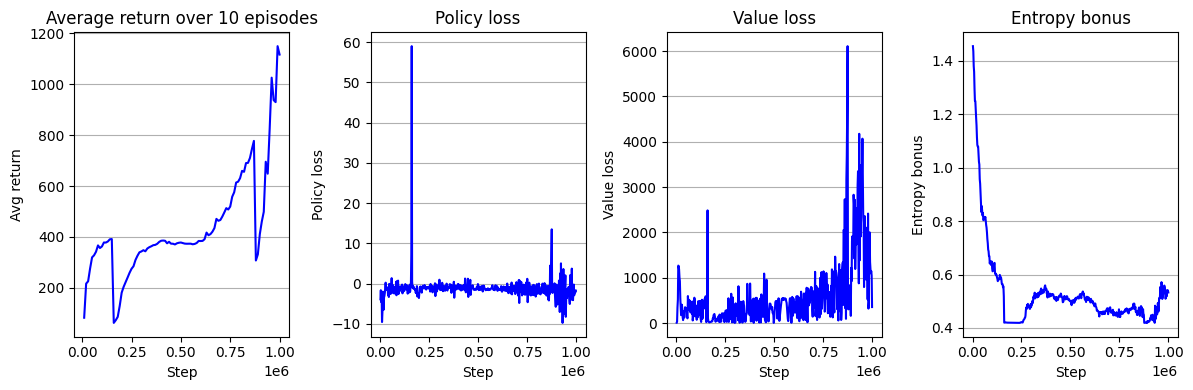

In [8]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 4, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 4, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 4, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

ax = fig.add_subplot(1, 4, 4)
key = 'entropy_bonus'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Entropy bonus")
ax.set_xlabel("Step")
ax.set_ylabel("Entropy bonus")

fig.tight_layout()
plt.show()

<br>

아니 왜 TRPO보다 성능이 안 좋아요? 코드 구현 제대로 안 한거 아니에요?라고 물어본다면 그건 바로 ReLU를 사용했기 때문이다! 이게 무슨 소리인가 싶을 것이다. 우리의 일반적인 믿음은 활성화 함수로는 ReLU가 hyperbolic tangent (tanh)보다 좋다는 것이다. 필자도 그렇게 생각했다. 그래서 필자가 예전에 PPO 논문을 읽고 직접 구현해볼 때 ReLU를 사용했었다. 그런데 논문에 보고한 성능에 훨씬 못 미치는 성능이 나오는 것이었다. 처음엔 내 코드에 버그가 있는줄 알았지, 오타가 있는줄 알았지, 구현 디테일을 빼고 구현해서 그런가 싶었지, 근데 며칠 동안 내 코드를 아무리 뜯어 보고 살펴 보고 남의 코드 따라써도 죽어도 결과가 안 나오던 것이었다. 논문에서 사용한 하이퍼파라미터 그대로 다 사용했었는데도 말이다. 

<br>

단 한 가지, 활성화 함수를 tanh 대신 ReLU를 사용한 것 제외하고는. 진짜 설마하는 마음으로 ReLU를 지우고 tanh를 사용하니 귀신 같이 논문에 보고한 성능에 가까워지는 것을 목격해버렸다. 그리고 나는 그때 깨달았다. On-policy 알고리즘은 학습에 있어서 굉장히 불안정하다는 것을. 그래서 학습 안정화를 위한 여러 코드 구현 디테일이 필요하다는 것을. 그 모든 디테일을 내가 알 수는 없으니 남이 잘 짜놓은 것을 갖다 쓰는게 좋다는 것을. 

<br>

팩트 체크 들어가보자. `activation_fn`을 `torch.tanh`으로 변경 후 돌려볼 것이다.

In [9]:
env_name = 'Hopper-v4'

seed = 0
seed_all(seed)
max_iterations = 1000000
eval_intervals = 10000
eval_iterations = 10
activation_fn = torch.tanh

env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
agent = PPO(
    state_dim,
    action_dim,
    activation_fn=activation_fn,
)

logger = []
(s, _), terminated, truncated = env.reset(seed=seed), False, False
for t in tqdm(range(1, max_iterations + 1)):
    a = agent.act(s)
    s_prime, r, terminated, truncated, _ = env.step(a)
    result = agent.step((s, a, r, s_prime, terminated))
    s = s_prime
    
    if result is not None:
        logger.append([t, 'policy_loss', result['policy_loss']])
        logger.append([t, 'value_loss', result['value_loss']])
        logger.append([t, 'entropy_bonus', result['entropy_bonus']])
    
    if terminated or truncated:
        (s, _), terminated, truncated = env.reset(), False, False
        
    if t % eval_intervals == 0:
        score = evaluate(env_name, agent, seed, eval_iterations)
        logger.append([t, 'Avg return', score])

100%|██████████| 1000000/1000000 [18:57<00:00, 879.07it/s]


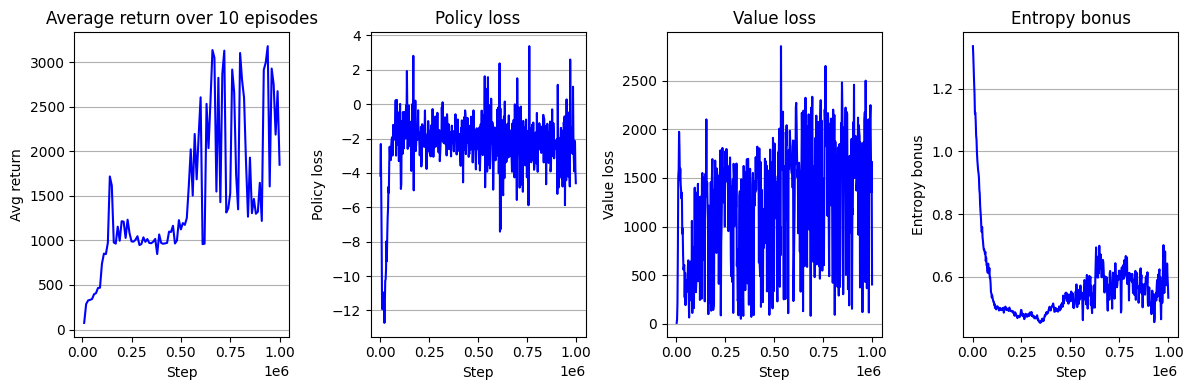

In [11]:
logger = pd.DataFrame(logger)
logger.columns = ['step', 'key', 'value']

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 4, 1)
key = 'Avg return'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Average return over 10 episodes")
ax.set_xlabel("Step")
ax.set_ylabel("Avg return")

ax = fig.add_subplot(1, 4, 2)
key = 'policy_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Policy loss")
ax.set_xlabel("Step")
ax.set_ylabel("Policy loss")

ax = fig.add_subplot(1, 4, 3)
key = 'value_loss'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Value loss")
ax.set_xlabel("Step")
ax.set_ylabel("Value loss")

ax = fig.add_subplot(1, 4, 4)
key = 'entropy_bonus'
ax.plot(logger.loc[logger['key'] == key, 'step'], logger.loc[logger['key'] == key, 'value'], 'b-')
ax.grid(axis='y')
ax.set_title("Entropy bonus")
ax.set_xlabel("Step")
ax.set_ylabel("Entropy bonus")

fig.tight_layout()
plt.show()

<br>

학습 곡선은 위와 같다. 모든 것이 동일하고 네트워크의 활성화 함수를 ReLu에서 tanh로 바꿔줬을 뿐인데 `Avg return`의 높이가 약 1.5배 높아진 것을 확인할 수 있다. 사실 사소한 코드 변화에 의해서 성능이 크게 달라지는 이러한 현상은 on-policy 알고리즘에 있어서 굉장히 흔한 일이다. 한편, 그래도 여전히 TRPO와 비슷한 수준의 성능이다. 실제 PPO 논문에서 보고하는 성능을 달성하기 위해서는 더 많은 구현 디테일이 필요하다. 다음 장에서는 사용하기 쉬운 구현 디테일 몇 가지를 알아보며 PPO 알고리즘을 개선해볼 것이다. 


<br>

```{raw} html
<script
   type="text/javascript"
   src="https://utteranc.es/client.js"
   async="async"
   repo="HiddenBeginner/Deep-Reinforcement-Learnings"
   issue-term="pathname"
   theme="github-light"
   label="💬 comment"
   crossorigin="anonymous"
/>
```